In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [20]:
# load in feature file
df_all = pd.read_csv('../Output/Submission/features/Features_Rescaled.csv')
df_all = df_all[df_all['ContourType'] == 'Manual']

fts_all = df_all['Feature'].unique()
patIDs = df_all['PatID'].unique()
fractions = df_all['Fraction'].unique()

In [21]:
fts_lng = pd.read_csv('../Output/Submission/features/Features_Selected.csv')
fts_lng = fts_lng['Feature'].unique()

fts_del = pd.read_csv('../Output/Submission-Delta/features/Features_Selected.csv')
fts_del = fts_del['Feature'].unique()

fts_sel = []
fts_sel.extend(fts_lng)
fts_sel.extend(fts_del)

df_all = df_all[df_all['Feature'].isin(fts_sel)]


In [22]:
df_all['Model'] = ''
df_all['Model'] = np.where(df_all['Feature'].isin(fts_lng), 'Longitudinal', df_all['Model'])
df_all['Model'] = np.where(df_all['Feature'].isin(fts_del), 'Delta', df_all['Model'])

df_all.sample(5)

,PatID,Fraction,Contour,ContourType,Feature,FeatureValue,Model
20849,1303,4,MS,Manual,glrlm_LongRunHighGrayLevelEmphasis,0.332191,Delta
19797,1431,4,RP,Manual,glrlm_HighGrayLevelRunEmphasis,0.571252,Longitudinal
20917,1303,5,MS,Manual,firstorder_Median,0.350649,Longitudinal
20733,1303,3,MS,Manual,glcm_JointEntropy,0.690726,Longitudinal
16689,752,4,MS,Manual,gldm_SmallDependenceLowGrayLevelEmphasis,0.360774,Delta


In [23]:
def get_max_change(df_change):
    '''
    Get the maximum change in feature value and the comp at which it occurs for every patient
    '''
    fts = df_change['Feature'].unique()
    patIDs = df_change['PatID'].unique()

    df_change_max = pd.DataFrame()

    for ft in fts:
        df_ft = df_change[df_change['Feature'] == ft]
        
        for pat in patIDs:
            df_pat = df_ft[df_ft['PatID'] == pat]
            
            # get row with max change
            max_change = df_pat['Change'].max()
            df_pat_max = df_pat[df_pat['Change'] == max_change]
    
    
            df_change_max = pd.concat([df_change_max, df_pat_max])
    
    return df_change_max

def get_max_change_no_delta(df_change):
    df_change = df_change[df_change['Comp'] != '1 - 5']

    fts = df_change['Feature'].unique()
    patIDs = df_change['PatID'].unique()

    df_change_max = pd.DataFrame()

    for ft in fts:
        df_ft = df_change[df_change['Feature'] == ft]
        
        for pat in patIDs:
            df_pat = df_ft[df_ft['PatID'] == pat]
            
            # get row with max change
            max_change = df_pat['Change'].max()
            df_pat_max = df_pat[df_pat['Change'] == max_change]
    
    
            df_change_max = pd.concat([df_change_max, df_pat_max])
    
    return df_change_max

In [24]:
# for each feature get difference from frac A > frac B
def get_change(df_ft, ft, fracA, fracB):
    '''
    Get the change in feature value from frac A to frac B
    '''
    fts_valsA = df_ft[df_ft['Fraction'] == fracA]['FeatureValue'].values
    fts_valsB = df_ft[df_ft['Fraction'] == fracB]['FeatureValue'].values
    ft_vals1 = df_ft[df_ft['Fraction'] == 1]['FeatureValue'].values

    df_change_temp = pd.DataFrame({'PatID': df_ft['PatID'].unique()})
    df_change_temp['Feature'] = ft
    df_change_temp['Comp'] = f'{fracA} - {fracB}'
    df_change_temp['Change'] = (abs(fts_valsB - fts_valsA))

    return df_change_temp


In [25]:
# get the change in feature value for each feature
df_change = pd.DataFrame()

for ft in fts_all:
    df_ft = df_all[df_all['Feature'] == ft]

    for i in range(int(len(fractions))):
        fracA = fractions[i]
        for j in range(i+1, int(len(fractions))):
            fracB = fractions[j]

            df_change_temp = get_change(df_ft, ft, fracA, fracB)
            df_change = pd.concat([df_change, df_change_temp], axis=0)

In [26]:
df_max_ch = pd.DataFrame()
df_max_ch_no_delta = pd.DataFrame()

df_max_ch = get_max_change(df_change)
df_max_ch_no_delta = get_max_change_no_delta(df_change)

df_max_ch


,PatID,Feature,Comp,Change
0,1642,firstorder_10Percentile,1 - 2,0.274194
1,713,firstorder_10Percentile,1 - 3,0.112903
2,1483,firstorder_10Percentile,3 - 5,0.483871
3,1089,firstorder_10Percentile,3 - 5,0.225806
4,829,firstorder_10Percentile,4 - 5,0.080645
...,...,...,...,...
15,826,gldm_SmallDependenceLowGrayLevelEmphasis,2 - 4,0.082789
16,1601,gldm_SmallDependenceLowGrayLevelEmphasis,1 - 5,0.143242
17,1481,gldm_SmallDependenceLowGrayLevelEmphasis,1 - 4,0.099724
18,1431,gldm_SmallDependenceLowGrayLevelEmphasis,1 - 4,0.063715


In [27]:
df_max_ch['Model'] = ''
df_max_ch['Model'] = np.where(df_max_ch['Feature'].isin(fts_lng), 'Longitudinal', df_max_ch['Model'])
df_max_ch['Model'] = np.where(df_max_ch['Feature'].isin(fts_del), 'Delta', df_max_ch['Model'])

In [28]:
def get_delta_change(df_all):

    '''
    Gets change between frac 1 and frac 5
    '''
    df_change = pd.DataFrame()

    for ft in fts_all:
        df_ft = df_all[df_all['Feature'] == ft]

        df_change_temp = get_change(df_ft, ft, 1, 5)
        df_change = pd.concat([df_change, df_change_temp], axis=0)
    
    return df_change

df_delta = get_delta_change(df_all)
df_delta.rename(columns={'Change': 'DeltaChange'}, inplace=True)
df_delta.drop(columns=['Comp'], inplace=True)


In [29]:
df_comp_ch = pd.merge(df_max_ch, df_delta, on=['PatID', 'Feature'], how='left')
df_comp_ch

,PatID,Feature,Comp,Change,Model,DeltaChange
0,1642,firstorder_10Percentile,1 - 2,0.274194,Delta,0.080645
1,713,firstorder_10Percentile,1 - 3,0.112903,Delta,0.064516
2,1483,firstorder_10Percentile,3 - 5,0.483871,Delta,0.016129
3,1089,firstorder_10Percentile,3 - 5,0.225806,Delta,0.096774
4,829,firstorder_10Percentile,4 - 5,0.080645,Delta,0.032258
...,...,...,...,...,...,...
381,826,gldm_SmallDependenceLowGrayLevelEmphasis,2 - 4,0.082789,Delta,0.003531
382,1601,gldm_SmallDependenceLowGrayLevelEmphasis,1 - 5,0.143242,Delta,0.143242
383,1481,gldm_SmallDependenceLowGrayLevelEmphasis,1 - 4,0.099724,Delta,0.074917
384,1431,gldm_SmallDependenceLowGrayLevelEmphasis,1 - 4,0.063715,Delta,0.007301


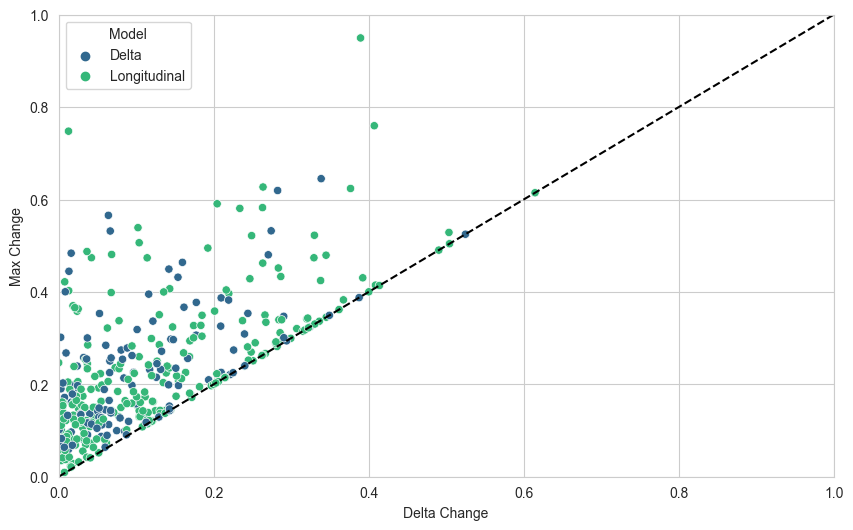

In [47]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(10, 6))

sns.scatterplot(data=df_comp_ch, x='DeltaChange', y='Change', hue='Model',
            palette='viridis', ax=ax)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Delta Change')
ax.set_ylabel('Max Change')
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()


<AxesSubplot:xlabel='Comp', ylabel='DistChange'>

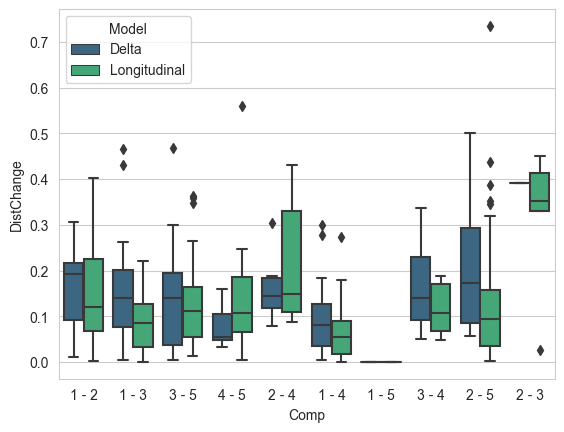

In [56]:
df_comp_ch_diff = df_comp_ch.copy()
df_comp_ch_diff['DistChange'] = df_comp_ch_diff['Change'] - df_comp_ch_diff['DeltaChange']

# sns.scatterplot(data=df_comp_ch_diff, x='Comp', y='DistChange', hue='Model')
sns.boxplot(data=df_comp_ch_diff, x='Comp', y='DistChange', palette='viridis', hue='Model')

<AxesSubplot:xlabel='DeltaChange', ylabel='DistChange'>

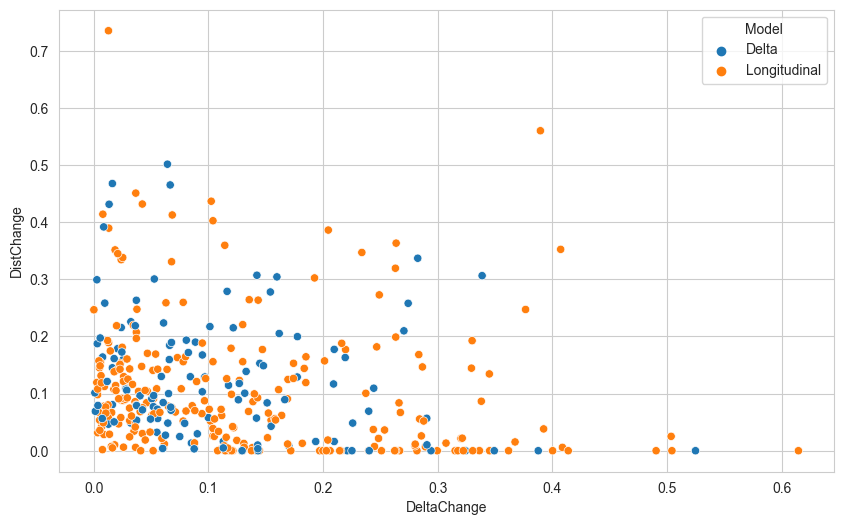

In [58]:
# plot of mac change vs delta change
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(10, 6))

sns.scatterplot(data=df_comp_ch_diff, x='DeltaChange', y='DistChange', hue='Model')

In [45]:
# measure distance between points and line x=y
df_comp_ch['Distance'] = np.sqrt((df_comp_ch['DeltaChange'] - df_comp_ch['Change'])**2)

# get mean distance for each model
df_comp_ch.groupby('Model')['Distance'].mean()



Model
Delta           0.125869
Longitudinal    0.104561
Name: Distance, dtype: float64

(0.0, 0.4)

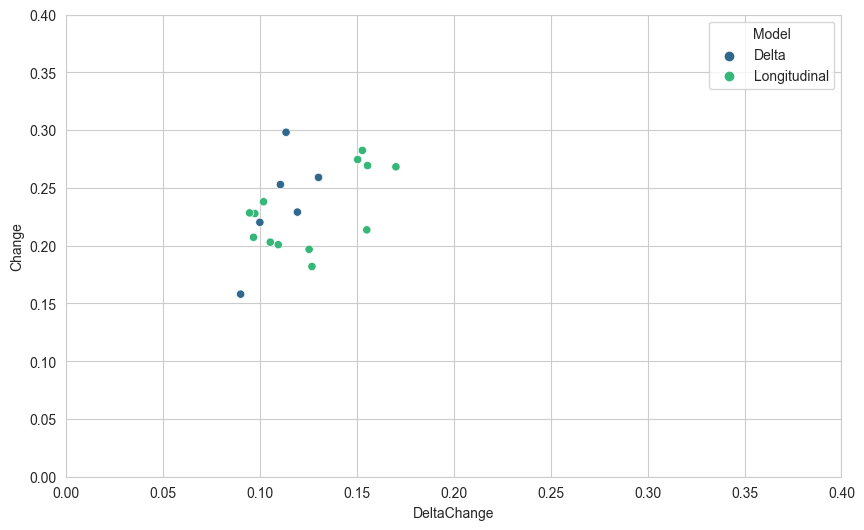

In [41]:
df_comp_ch_mean = df_comp_ch.groupby(['Feature'])[['Change', 'DeltaChange']].mean().reset_index()
df_comp_ch_mean['Model'] = ''
df_comp_ch_mean['Model'] = np.where(df_comp_ch_mean['Feature'].isin(fts_lng), 'Longitudinal', df_comp_ch_mean['Model'])
df_comp_ch_mean['Model'] = np.where(df_comp_ch_mean['Feature'].isin(fts_del), 'Delta', df_comp_ch_mean['Model'])

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(10, 6))

sns.scatterplot(data=df_comp_ch_mean, x='DeltaChange', y='Change', palette='viridis', hue='Model', ax=ax)
ax.set_xlim(0, 0.4)
ax.set_ylim(0, 0.4)